In [ ]:
"""
Image Classification
Classifying images from the CIFAR-10 dataset. The dataset consists of airplanes, dogs, cats, and other objects.
Preprocess the images, then train a convolutional neural network on all the samples. 
The images need to be normalized and the labels need to be one-hot encoded. 
Applying  and building a convolutional, max pooling, dropout, and fully connected layers. 
Check neural network's predictions on the sample images.

Get the Data
Run the following cell to download the CIFAR-10 dataset for python.
Data
CIFAR-10 is an established computer-vision dataset used for object recognition. 
It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes,
with 6000 images per class. 
It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

"""

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()
        
# Data loaded in current working directory.

CIFAR-10 Dataset: 171MB [00:44, 3.79MB/s]                                                                              


In [35]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # total_features*RGB*H*W
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1) #(len, 32, 32, 3)
    labels = batch['labels']
    
#     print(batch['data'])
#     print("-"*80)
#     print(batch['data'].reshape((len(batch['data']), 3, 32, 32)))
#     print("-"*80)
#     print(features)
#     print("-"*80)
#     print(labels)

    return features, labels


def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)


def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1) #10%

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the test data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all test data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_testing.p')


def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 5
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])



Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 160:
Image - Min Value: 33 Max Value: 242
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


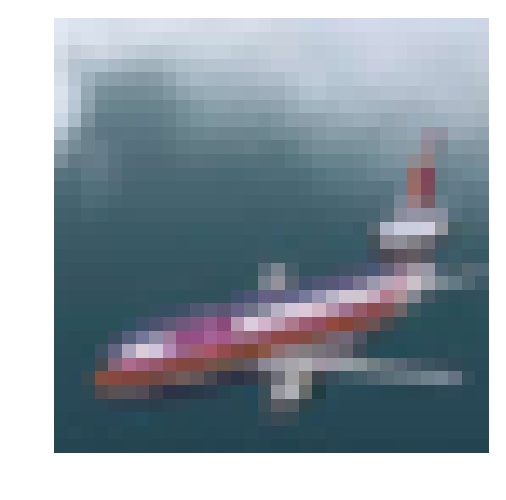

In [39]:
%matplotlib inline
% config InlineBackend.figure_format = 'retina'

import numpy as np
batch_id=4
sample_id=160
display_stats(cifar10_dataset_folder_path,batch_id,sample_id)

In [ ]:
# Implementation of preprocess function and solution code

In [40]:
# NORMALIZE

import numpy as np
def normalize(x):
    """ normalizes a list of image data in 0 to 1 range.
    x: list of image data. Image shape is (32,32,3)
    return: numpy arrray of normalized data.
    
    here we use min max, can also use Z-mean/sigma
    """
    x=np.array(x)
    x_max=np.max(x)
    x_min=np.min(x)
    output=(x-x_min)/(x_max - x_min)
    return output

In [41]:
# ONE_HOT_ENCODE

from sklearn.preprocessing import LabelBinarizer
lb=LabelBinarizer()
lb.fit(range(10))

def one_hot_encode(x):
    
    """
    One hot encode's a list of sample labels.
    returns a one-hot-encoded vectors
    x:List of sample labels
    return: Numpy array of one-hot-encoded labels
    """
    
    return lb.transform(x)  # between 0-9


In [ ]:
# Randomize data: since order is randomized already so we dont need to
# randomize the data, else we can shuffle n whatnot

In [42]:
# Preprocess all the data and save
preprocess_and_save_data(cifar10_dataset_folder_path,normalize,one_hot_encode)

In [43]:
# 10% of training data is validation.
valid_features,valid_labels=pickle.load(open('preprocess_validation.p',mode='rb'))

In [46]:
# example
print(valid_features[0])
print('_____________')
print(valid_labels[0])

[[[0.54901961 0.49019608 0.45098039]
  [0.57254902 0.50980392 0.47843137]
  [0.56078431 0.49803922 0.47843137]
  ...
  [0.66666667 0.56862745 0.51372549]
  [0.69019608 0.58823529 0.5254902 ]
  [0.66666667 0.57647059 0.52156863]]

 [[0.4745098  0.42352941 0.50588235]
  [0.50980392 0.4627451  0.54509804]
  [0.5254902  0.4745098  0.56078431]
  ...
  [0.63921569 0.55294118 0.61568627]
  [0.66666667 0.57254902 0.63137255]
  [0.66666667 0.58039216 0.63137255]]

 [[0.59607843 0.54509804 0.68235294]
  [0.61568627 0.56862745 0.70196078]
  [0.60784314 0.56078431 0.68627451]
  ...
  [0.69411765 0.60392157 0.75686275]
  [0.70980392 0.61176471 0.76078431]
  [0.71764706 0.62745098 0.76078431]]

 ...

 [[0.49019608 0.43137255 0.4       ]
  [0.50588235 0.43921569 0.40392157]
  [0.29803922 0.2627451  0.18431373]
  ...
  [0.65882353 0.5372549  0.47058824]
  [0.61960784 0.49411765 0.40392157]
  [0.57254902 0.45490196 0.34117647]]

 [[0.33333333 0.30196078 0.2745098 ]
  [0.36862745 0.31764706 0.27843137]


In [48]:
# Building the network

# INPUT

import tensorflow as tf

def neural_net_image_input(image_shape):
    """Returns a tensor for a batch of image input.
    image_shape=Shape of the image
    return : tensor for image input
    
    """
    return tf.placeholder(tf.float32,shape=[None,image_shape[0],image_shape[1],image_shape[2]], name='x')

def neural_net_label_input(n_classes):
    return tf.placeholder(tf.float32,shape=[None,n_classes], name='y')

def neural_net_keep_prob_input():
    return tf.placeholder(tf.float32, shape=(None),name='keep_prob')

tf.reset_default_graph()

C:\Users\gaura\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [65]:
# Convolution and max pooling layer

def conv2d_maxpool(x_tensor,conv_num_outputs,conv_ksize,conv_strides,pool_ksize,pool_strides):
    
    """
    x_tensor is tensorflow tensor
    conv_num_outputs=number of outputs for the conv layer
    conv_strides is 2-D tuple 
    pool_ksize 2-D tuple for maxpool etc
    returns a tensor that represents convolution and maxpooling of x_tensor
    """
    
    shape_of_x_tensor=x_tensor.get_shape().as_list()
    F_W=tf.Variable(tf.truncated_normal([conv_ksize[0],conv_ksize[1],shape_of_x_tensor[-1] ,conv_num_outputs],
                                       dtype=tf.float32, stddev=0.2))
    F_b=tf.Variable(tf.zeros((conv_num_outputs)),dtype=tf.float32)
    
    strides_conv= [1,conv_strides[0],conv_strides[1],1]
    
    padding='SAME'
    
    output=tf.nn.conv2d(x_tensor,F_W,strides_conv,padding)
    
    output=tf.nn.bias_add(output,F_b)
    
    output= tf.nn.relu(output)
    
    ksize_maxpool=[1,pool_ksize[0],pool_ksize[1],1]
    strides_maxpool=[1,pool_strides[0],pool_strides[1],1]
    
    output=tf.nn.max_pool(output,ksize_maxpool,strides_maxpool,padding)
    
    return output




In [66]:
# Flatten Layer

# Implement the faltten function to change the dimension of x_tensor from
# 4D to 2D tensor. output is shape(batch size,Flattened image size)

def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    shape=x_tensor.get_shape().as_list()
    flat_dim=shape[1]*shape[2]*shape[3]
    output=tf.reshape(x_tensor,[-1,flat_dim])
    return output


    

In [72]:
# Fully connected layer

def fully_conn(x_tensor,num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    shape=x_tensor.get_shape().as_list()
    weights=tf.Variable(tf.truncated_normal([shape[1],num_outputs],dtype=tf.float32, stddev=0.2))
    biases=tf.Variable(tf.zeros((num_outputs)),dtype=tf.float32)
    
    out=tf.add(tf.matmul(x_tensor,weights),biases)
    out=tf.nn.relu(out)
    
    return out
    

In [73]:
# output layer

def output(x_tensor,num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    
    shape=x_tensor.get_shape().as_list()
    weights=tf.Variable(tf.truncated_normal([shape[1],num_outputs],dtype=tf.float32,stddev=.2))
    biases=tf.Variable(tf.zeros((num_outputs)),dtype=tf.float32)
    
    out=tf.add(tf.matmul(x_tensor,weights),biases)
    return out

In [74]:
# Create Convolution Model
"""

Implementing the function conv_net to create a convolutional neural network model. 
The function takes in a batch of images, x, and outputs logits.
Use the layers you created above to create this model:
Apply 1, 2, or 3 Convolution and Max Pool layers
Apply a Flatten Layer
Apply 1, 2, or 3 Fully Connected Layers
Apply an Output Layer
Return the output
Applying TensorFlow's Dropout to one or more layers in the model using keep_prob.
"""


"\n\nImplementing the function conv_net to create a convolutional neural network model. \nThe function takes in a batch of images, x, and outputs logits.\nUse the layers you created above to create this model:\nApply 1, 2, or 3 Convolution and Max Pool layers\nApply a Flatten Layer\nApply 1, 2, or 3 Fully Connected Layers\nApply an Output Layer\nReturn the output\nApplying TensorFlow's Dropout to one or more layers in the model using keep_prob.\n"

In [75]:
def conv_net(x,keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    out = conv2d_maxpool(x, conv_num_outputs = 16, conv_ksize = (3,3), conv_strides = (1,1), pool_ksize=(2,2), pool_strides=(2,2))
    out = conv2d_maxpool(out, conv_num_outputs = 32, conv_ksize = (3,3), conv_strides = (1,1), pool_ksize=(2,2), pool_strides=(2,2))
    out = conv2d_maxpool(out, conv_num_outputs = 64, conv_ksize = (3,3), conv_strides = (1,1), pool_ksize=(2,2), pool_strides=(2,2))
    
    out=flatten(out)
    
    out=fully_conn(out,num_outputs=64)
    out=tf.nn.dropout(out,keep_prob)
    out=fully_conn(out,num_outputs=32)
    out=tf.nn.dropout(out,keep_prob)
    out = fully_conn(out, num_outputs = 16)
    #    Set this to the number of classes
    # Function Definition from Above:
    out = output(out, num_outputs = 10)

    return out    

In [77]:
# Build Neural Network
# Remove previous weights,bias,inputs, etc ..
tf.reset_default_graph()

# Inputs
x=neural_net_image_input((32,32,3))
y=neural_net_label_input(10)
keep_prob=neural_net_keep_prob_input()

# Model
logits=conv_net(x,keep_prob)

# Name logits Tensor, so that it can be loaded from disk after training
logits=tf.identity(logits,name='logits')

# Loss and Optimizer
cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y))
optimizer=tf.train.AdamOptimizer().minimize(cost)

# Accuracy

correct_pred=tf.equal(tf.argmax(logits,1),tf.argmax(y,1))
accuracy=tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')




In [78]:
# Train Neural Network
# Single Optimization

def train_neural_network(session,optimizer,keep_probability,feature_batch,label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer,feed_dict={x:feature_batch,y:label_batch,keep_prob:keep_probability})



In [79]:
# Show stats

def print_stats(session,feature_batch,label_batch,cost,accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    valid_acc= sess.run(accuracy,feed_dict={
                x:valid_features,
                y:valid_labels,
                keep_prob:1.0 })
    train_acc = sess.run(accuracy, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1.})
    train_cost = sess.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1.})
    
    print('Cost{::>8.5f},Accuracy on Training {:.4f}-'
         'Validation Accuracy:{:.4f}'.format(train_cost,train_acc,valid_acc))

In [ ]:
# Hyperparameters
"""
Set epochs to the number of iterations until the network stops learning or start overfitting.

Set batch_size to the highest number that your machine has memory for.
Most people set them to common sizes of memory:
64
128
256
...
Set keep_probability to the probability of keeping a node using dropout.
"""

In [90]:
epochs=5 # because of memory n computational limitations i am using only 5 epochs.Shud be 100-150.
batch_size=256
keep_probability=0.75


In [89]:
# Train on a single CIFAR-10 Batch

print('Checking the training on a single batch')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    
    for epoch in range(epochs):
        batch_i=1
        for batch_features,batch_labels in load_preprocess_training_batch(batch_i,batch_size):
            train_neural_network(sess,optimizer,keep_probability,batch_features,batch_labels)
        print('Epoch{:>2},CIFAR-10 Batch {}:'.format(epoch +1,batch_i,end=''))
        print_stats(sess, batch_features, batch_labels, cost, accuracy)
        

Checking the training on a single batch
Epoch 1,CIFAR-10 Batch 1:
Cost:2.29429,Accuracy on Training 0.1500-Validation Accuracy:0.1060
Epoch 2,CIFAR-10 Batch 1:
Cost:2.25649,Accuracy on Training 0.1500-Validation Accuracy:0.1508
Epoch 3,CIFAR-10 Batch 1:
Cost:2.22711,Accuracy on Training 0.1750-Validation Accuracy:0.1602
Epoch 4,CIFAR-10 Batch 1:
Cost:2.19925,Accuracy on Training 0.2500-Validation Accuracy:0.2114
Epoch 5,CIFAR-10 Batch 1:
Cost:2.14291,Accuracy on Training 0.2750-Validation Accuracy:0.2586
Epoch 6,CIFAR-10 Batch 1:
Cost:2.07609,Accuracy on Training 0.3250-Validation Accuracy:0.2808
Epoch 7,CIFAR-10 Batch 1:
Cost:1.99798,Accuracy on Training 0.2500-Validation Accuracy:0.3262
Epoch 8,CIFAR-10 Batch 1:
Cost:1.90352,Accuracy on Training 0.2750-Validation Accuracy:0.3476
Epoch 9,CIFAR-10 Batch 1:
Cost:1.83737,Accuracy on Training 0.3750-Validation Accuracy:0.3604
Epoch10,CIFAR-10 Batch 1:
Cost:1.77327,Accuracy on Training 0.4000-Validation Accuracy:0.3746


In [92]:
# Fully train model

save_model_path='./image_classification'
print('Training....')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        n_batches=5
        for batch_i in range(1,n_batches +1):
            for batch_features,batch_labels in load_preprocess_training_batch(batch_i,batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)                
        

Training....
Epoch  1, CIFAR-10 Batch 1:  Cost:2.28173,Accuracy on Training 0.1750-Validation Accuracy:0.1570
Epoch  1, CIFAR-10 Batch 2:  Cost:2.23662,Accuracy on Training 0.1250-Validation Accuracy:0.2106
Epoch  1, CIFAR-10 Batch 3:  Cost:2.02129,Accuracy on Training 0.2000-Validation Accuracy:0.2456
Epoch  1, CIFAR-10 Batch 4:  Cost:2.03841,Accuracy on Training 0.2000-Validation Accuracy:0.2798
Epoch  1, CIFAR-10 Batch 5:  Cost:1.92528,Accuracy on Training 0.3500-Validation Accuracy:0.2976
Epoch  2, CIFAR-10 Batch 1:  Cost:1.95462,Accuracy on Training 0.4000-Validation Accuracy:0.3308
Epoch  2, CIFAR-10 Batch 2:  Cost:1.88372,Accuracy on Training 0.4250-Validation Accuracy:0.3390
Epoch  2, CIFAR-10 Batch 3:  Cost:1.61255,Accuracy on Training 0.4250-Validation Accuracy:0.3508
Epoch  2, CIFAR-10 Batch 4:  Cost:1.68409,Accuracy on Training 0.3250-Validation Accuracy:0.3724
Epoch  2, CIFAR-10 Batch 5:  Cost:1.73063,Accuracy on Training 0.3500-Validation Accuracy:0.3554
Epoch  3, CIFAR-1

In [ ]:
# test model.# accuracy will be low as we used only 5 epochs

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.49365234375



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


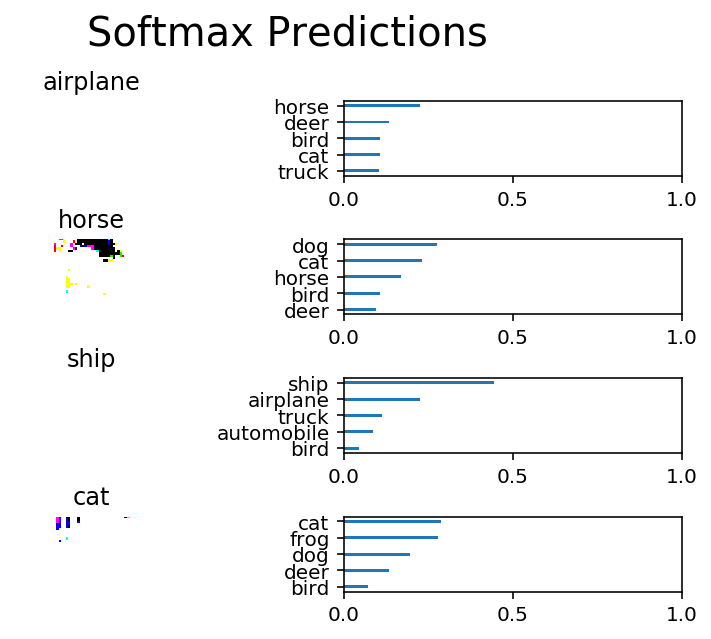

In [93]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 5

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_testing.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

In [ ]:
# Accuracy will improve if we invcrease epochs ...for memory
# limitations and speed up things we used only 5 epochs.
# still its giving acccuracy ~ 50%